## Prerequisites

In [1]:
from IPython.display import clear_output
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from typing import List
from tqdm.notebook import tqdm

!pip install transformers SentencePiece pytorch-lightning

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import pytorch_lightning as pl
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import recall_score
import torchmetrics
import pickle
import os

clear_output()

In [2]:
df = pd.DataFrame()

for file in os.listdir('./tok/'):
    try:
      if file.endswith('.csv'):
        file_path = os.path.join('./tok/', file)
        df1 = pd.read_csv(file_path, encoding = "CP949")
        df = pd.concat([df, df1], axis = 0).reset_index(drop = True)
    except:
      pass

## Preprocessings

In [4]:
translate = {
    'sadness': '슬픔',
    'anger': '분노',
    'disgust': '상처',
    'happiness': '기쁨',
    'fear': '불안',
    'surprise': '당황',
    'neutral' : '중립'
}

df['상황'] = df['상황'].map(translate)
df['상황'].value_counts()

슬픔    14000
분노    11635
상처     4660
기쁨     4548
불안     4131
중립     3262
당황     1755
Name: 상황, dtype: int64

In [6]:
from sklearn.model_selection import train_test_split

train_dataset, test_val = train_test_split(df , train_size = 0.70, stratify=df['상황'], random_state=77)
test_dataset, val_dataset = train_test_split(test_val, train_size = 0.30, stratify=test_val['상황'], random_state=77)

In [7]:
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))
print("VAL Dataset: {}".format(val_dataset.shape))

TRAIN Dataset: (30793, 2)
TEST Dataset: (3959, 2)
VAL Dataset: (9239, 2)


In [8]:
X_train = train_dataset.drop(['상황'], axis = 1)
y_train = train_dataset['상황']
X_test = test_dataset.drop(['상황'], axis = 1)
y_test = test_dataset['상황']
X_val = val_dataset.drop(['상황'], axis = 1)
y_val = val_dataset['상황']

In [9]:
le = preprocessing.LabelEncoder()

train_labels = le.fit_transform(y_train.values)

In [10]:
num_unique_labels = len(le.classes_)
print("독립적인 레이블의 개수:", num_unique_labels)

독립적인 레이블의 개수: 7


In [11]:
MAX_LEN = 32
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = 128
tokenizer = AutoTokenizer.from_pretrained("a2ran/sent_cognition")

In [12]:
class Dataset_Generation:
    def __init__(self, df, labels, tokenizer, max_len):
        self.len = len(df)
        self.data = df
        self.tokenizer = tokenizer
        self.labels = labels
        self.max_len = max_len

    def __getitem__(self, idx):
        title = " ".join(str(_) for _ in self.data.loc[idx, :].values)
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding = 'max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.labels[idx], dtype=torch.long)
        }

    def __len__(self):
        return self.len

In [13]:
train_dataset = X_train
test_dataset = X_test
val_dataset = X_val
train_dataset = train_dataset.reset_index(drop=True)
test_dataset = test_dataset.reset_index(drop=True)
val_dataset = val_dataset.reset_index(drop=True)

test_labels = le.transform(y_test.values)
val_labels = le.transform(y_val.values)
train_set = Dataset_Generation(train_dataset, train_labels, tokenizer, MAX_LEN)
test_set = Dataset_Generation(test_dataset, test_labels, tokenizer, MAX_LEN)
val_set = Dataset_Generation(val_dataset, val_labels, tokenizer, MAX_LEN)

In [14]:
import torch

first_item = train_set[0]

for key, value in first_item.items():
    print(f"{key}: {value}")

ids: tensor([   2, 3219, 1568, 3034, 1915, 2902,  812, 3192, 3665, 2836, 3236, 2849,
         649, 1924, 1554, 2868,   10,    3,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1])
mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
targets: 5


In [15]:
decoded_text = tokenizer.decode(first_item['ids'])
print(decoded_text)

[CLS] 면접에 떨어졌다는 소식을 듣고 너무 실망해서 밥맛도 없어. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [16]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 8,
                'pin_memory' :True
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'num_workers': 8,
                'pin_memory' :True
                }

val_params = {'batch_size': VALID_BATCH_SIZE,
                'num_workers': 8,
                'pin_memory' :True
                }

train_loader = DataLoader(train_set, **train_params)
test_loader = DataLoader(test_set, **test_params)
val_loader = DataLoader(val_set, **val_params)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Classifier

In [17]:
!pip install -q x-transformers

In [89]:
import torch.nn as nn
import torch.nn.functional as F

class Atn_Layer(nn.Module):
    def __init__(self, input_dim):
        super(Atn_Layer, self).__init__()
        self.input_dim = input_dim
        self.W = nn.Linear(input_dim, input_dim)
        self.V = nn.Linear(input_dim, 1)

    def forward(self, x):
        energy = torch.tanh(self.W(x))
        attention = F.softmax(self.V(energy), dim=1)
        weighted = torch.sum(attention * x, dim=1)

        return weighted

class NN_Classifier(nn.Module):
    def __init__(self, input_dim = 4096, output_dim = 7, dropout_prob = 0.1,
                 attention_dim = 2045, num_filters = 128, kernel_size = 3, num_layers = 3):
        super(NN_Classifier, self).__init__()

        self.conv1d_layers = nn.ModuleList([nn.Conv1d(in_channels = (1 if _ == 0 else num_filters),
                                                    out_channels = num_filters,
                                                    kernel_size = kernel_size) for _ in range(num_layers)])

        self.maxpool = nn.MaxPool1d(kernel_size = 2)
        self.fc = nn.Linear(attention_dim, output_dim)

        self.dropout = nn.Dropout(dropout_prob)
        self.activation = nn.Tanh()

        self.attention = Atn_Layer(2045)

    def forward(self, x):
        x = x.unsqueeze(1)

        for conv1d_layer in self.conv1d_layers:
            conv1d_out = conv1d_layer(x)
            conv1d_out = self.activation(conv1d_out)
            x = conv1d_out

        pooled = self.maxpool(conv1d_out).squeeze(2)

        attended = self.attention(pooled)

        fc_input = self.dropout(attended)
        fc_out = self.fc(fc_input)

        return fc_out

In [90]:
classifier = NN_Classifier()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The Classifier has {count_parameters(classifier):,} trainable parameters')

The Classifier has 4,299,510 trainable parameters


## Encoder

In [92]:
from typing import Any
import pytorch_lightning as pl
from transformers import get_scheduler
from torch.optim import AdamW, Optimizer
from x_transformers import TransformerWrapper, Encoder
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

class Text_Classification(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.save_hyperparameters()

        self.encoder = TransformerWrapper(
            num_tokens = 4096,
            max_seq_len = 64,
            attn_layers = Encoder(
                dim = 512,
                depth = 6,
                heads = 8,
                macaron = True,
                attn_gate_values = True,
                attn_num_mem_kv = 16
            )
        )

        self.classifier = NN_Classifier()

        self.loss_function = torch.nn.CrossEntropyLoss()
        self.predictions = []
        self.targets = []
        self.confusion_matrix = None

    def forward(self, input_ids, attention_mask=None):
        encoder_output = self.encoder(input_ids)
        cls_representation = encoder_output[:, 0]
        logits = self.classifier(cls_representation)
        return logits

    def training_step(self, batch, batch_idx):
        ids = batch['ids']
        mask = batch['mask']
        targets = batch['targets']

        outputs = self(ids, mask)
        loss = self.loss_function(outputs, targets)

        self.log('train_loss', loss, prog_bar = True)
        self.log('train_acc', self.calculate_accuracy(outputs, targets), prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        ids = batch['ids']
        mask = batch['mask']
        targets = batch['targets']

        outputs = self(ids, mask)
        loss = self.loss_function(outputs, targets)

        _, predicted = torch.max(outputs, dim=1)

        class_acc = self.calculate_class_accuracy(outputs, targets)
        for i, acc in enumerate(class_acc):
            self.log(f'test_acc_class_{i}', acc, prog_bar=True)

        precision = precision_score(targets.detach().cpu(), predicted.detach().cpu(), average='weighted')
        recall = recall_score(targets.detach().cpu(), predicted.detach().cpu(), average='weighted')
        f1 = f1_score(targets.detach().cpu(), predicted.detach().cpu(), average='weighted')

        self.log('test_precision', precision, prog_bar=True)
        self.log('test_recall', recall, prog_bar=True)
        self.log('test_f1', f1, prog_bar=True)
        self.log('test_loss', loss, prog_bar = True)
        self.log('test_acc', self.calculate_accuracy(outputs, targets), prog_bar=True)

        self.predictions.append(predicted.detach().cpu())
        self.targets.append(targets.detach().cpu())

    def on_test_epoch_end(self):
        all_targets = torch.cat(self.targets, dim=0)
        all_predicted = torch.cat(self.predictions, dim=0)

        cm = confusion_matrix(all_targets.numpy(), all_predicted.numpy())
        self.confusion_matrix = cm

    def validation_step(self, batch, batch_idx):
        ids = batch['ids']
        mask = batch['mask']
        targets = batch['targets']

        outputs = self(ids, mask)
        loss = self.loss_function(outputs, targets)

        class_acc = self.calculate_class_accuracy(outputs, targets)
        for i, acc in enumerate(class_acc):
            self.log(f'val_acc_class_{i}', acc, prog_bar=True)

        self.log('val_loss', loss, prog_bar = True)
        self.log('val_acc', self.calculate_accuracy(outputs, targets), prog_bar=True)

    def configure_optimizers(self) -> tuple[list[Optimizer], list[dict[str, Any]]]:
        do_decay = [p for p in self.parameters() if p.requires_grad and p.ndim >= 2]
        no_decay = [p for p in self.parameters() if p.requires_grad and p.ndim < 2]
        param_groups = [{"params": do_decay}, {"params": no_decay, "weight_decay": 0.0}]

        optimizer = AdamW(param_groups, **self.config.optim.optimizer)
        scheduler = get_scheduler(optimizer=optimizer, **self.config.optim.scheduler)
        return [optimizer], [{"scheduler": scheduler, "interval": "step"}]

    @staticmethod
    def calculate_accuracy(preds, targets):
        _, predicted = torch.max(preds, dim=1)
        correct = torch.sum(predicted == targets)
        acc = correct.float() / targets.size(0)
        return acc

    @staticmethod
    def calculate_class_accuracy(preds, targets):
        _, predicted = torch.max(preds, dim=1)
        class_correct = list(0. for i in range(7))
        class_total = list(0. for i in range(7))

        for p, t in zip(predicted, targets):
            class_correct[t] += (p == t).item()
            class_total[t] += 1

        class_accuracy = [correct / total if total > 0 else 0.0 for correct, total in zip(class_correct, class_total)]

        return class_accuracy

    def train_dataloader(self):
        return train_loader

    def test_dataloader(self):
        return test_loader

    def val_dataloader(self):
        return val_loader

In [93]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    mode='min',
    verbose=True
)

checkpoint = ModelCheckpoint(
    monitor="val_loss", mode="min", save_weights_only=True
)

trainer = Trainer(
    accelerator="gpu",
    devices="auto",
    precision=16,
    log_every_n_steps = 100,
    max_epochs=20,
    gradient_clip_val=0,
    accumulate_grad_batches=1,
    val_check_interval=1.0,
    callbacks=[checkpoint, LearningRateMonitor("step"), early_stopping],
)

from easydict import EasyDict

config = EasyDict({})
config.optim = {}
config.optim.optimizer = {}
config.optim.optimizer.lr = 1e-4
config.optim.optimizer.eps = 1e-6
config.optim.optimizer.weight_decay = 1e-6
config.optim.scheduler = {}
config.optim.scheduler.name = "linear"
config.optim.scheduler.num_warmup_steps = 1_000
config.optim.scheduler.num_training_steps = 100_000

/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:565: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


In [94]:
trainer.fit(Text_Classification(config), train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type               | Params
-----------------------------------------------------
0 | encoder       | TransformerWrapper | 37.4 M
1 | classifier    | NN_Classifier      | 4.3 M 
2 | loss_function | CrossEntropyLoss   | 0     
-----------------------------------------------------
41.7 M    Trainable params
0         Non-trainable params
41.7 M    Total params
166.849   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.787


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.318 >= min_delta = 0.0. New best score: 0.469


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 0.411


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.384


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: 0.384. Signaling Trainer to stop.


In [95]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

!apt-get -qq install fonts-nanum
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    name='NanumGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'})

In [96]:
checkpoint_path = trainer.checkpoint_callback.best_model_path
checkpoint_path

'/content/lightning_logs/version_20/checkpoints/epoch=4-step=1205.ckpt'

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_20/checkpoints/epoch=4-step=1205.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_20/checkpoints/epoch=4-step=1205.ckpt
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8787572383880615     │
│     test_acc_class_0      │    0.8936448097229004     │
│     test_acc_class_1      │    0.8595765829086304     │
│     test_acc_class_2      │    0.8910344243049622     │
│     test_acc_class_3      │    0.8321616649627686     │
│     test_acc_class_4      │    0.7844135165214539     │
│     test_acc_class_5      │    0.9343172907829285     │
│     test_acc_class_6      │    0.7997381091117859     │
│          test_f1          │    0.8778889964661594     │
│         test_loss         │    0.3792198896408081     │
│      test_precision       │    0.8865747768331472     │
│        test_recall        │    0.8787572619348321     │
└───────────────────────────┴───────────────────────────┘

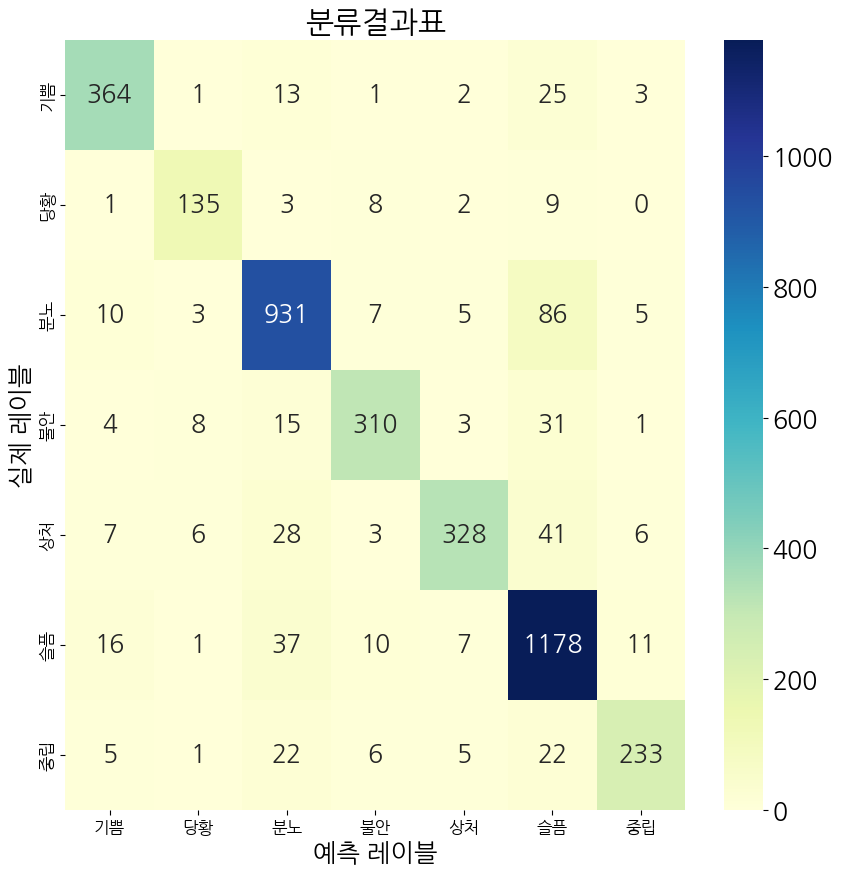

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu")
    plt.title('분류결과표')
    plt.xlabel('예측 레이블')
    plt.ylabel('실제 레이블')
    plt.xticks(ticks=np.arange(len(labels))+0.5, labels=labels, fontsize = 12)
    plt.yticks(ticks=np.arange(len(labels))+0.5, labels=labels, fontsize = 12)
    plt.show()

labels = le.inverse_transform(np.arange(len(le.classes_)))

model = Text_Classification(config)
trainer.test(model, ckpt_path=checkpoint.best_model_path, dataloaders=[test_loader])
plot_confusion_matrix(model.confusion_matrix, labels)

In [99]:
import shutil

checkpoint_path = trainer.checkpoint_callback.best_model_path
drive_path = "/content/drive/MyDrive/KSPI_코드/text_model.ckpt"

shutil.copy(checkpoint_path, drive_path)
drive.flush_and_unmount()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
